# Data analysis

## Import dependencies

In [1]:
import os
import json
import numpy as np
import pandas as pd
import random
import zipfile
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns


## Downloading the data

In [2]:
import kagglehub

path = "/root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1"
if not os.path.exists(path):
  # Download latest version
  path = kagglehub.dataset_download("himanshuwagh/spotify-million")

  print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [00:48<00:00, 115MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1


## What type of data do we have? What do we need?

In [3]:
print(os.listdir(path))

['license.txt', 'src', 'README.md', 'stats.txt', 'data', 'md5sums']


In [4]:
mpdslices_dir: str = os.path.join(path, "data")
mpdslices_lst = sorted(os.listdir(mpdslices_dir))
print(mpdslices_dir,
      ':\n [', mpdslices_lst[0], ", ... ,", mpdslices_lst[-1],']')

/root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1/data :
 [ mpd.slice.0-999.json , ... , mpd.slice.999000-999999.json ]


In [5]:
all_slices = [f for f in mpdslices_lst if f.startswith("mpd.slice.") and f.endswith(".json")]
print('The dataset is splitted into', len(all_slices),'slices, each one is a JSON files')

es = dict
with open(os.path.join(mpdslices_dir, all_slices[0]), 'r') as f:
        es = json.load(f)

The dataset is splitted into 1000 slices, each one is a JSON files


In [6]:
print(f'the type of the data extracted is {type(es)}')

the type of the data extracted is <class 'dict'>


Vediamo ora che dati dobbiamo maneggiare:

Dalle documentazioni abbiamo visto che ogni slice è un dizionario con chiavi 'info' e 'playlists'.
che c'è scritto su 'info'?

In [7]:
print(es['info'])

{'generated_on': '2017-12-03 08:41:42.057563', 'slice': '0-999', 'version': 'v1'}


Nulla di interessante, ora vediamo 'playlists'

In [8]:
print(type(es))
print(list(es['playlists'][0].keys()))
print(list(es['playlists'][0]['tracks'][0].keys()))
print('\nFirst song of the first playlist:')
es['playlists'][0]['tracks'][0]

<class 'dict'>
['name', 'collaborative', 'pid', 'modified_at', 'num_tracks', 'num_albums', 'num_followers', 'tracks', 'num_edits', 'duration_ms', 'num_artists']
['pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']

First song of the first playlist:


{'pos': 0,
 'artist_name': 'Missy Elliott',
 'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
 'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk',
 'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)',
 'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
 'duration_ms': 226863,
 'album_name': 'The Cookbook'}

Segnamoci ora gli attributi che ci interessano (essendo generosi)

In [9]:
keep_p = ['name', 'pid', 'num_tracks', 'num_albums', 'num_followers',
           'num_edits', 'duration_ms', 'num_artists', 'collaborative']
# we still keep 'tracks' but its a special case
keep_t = ['track_name', 'artist_name', 'track_uri']
# this way we only save the useful stuff from the JSON file

## Creating the dataframe

In [10]:
subset_size = 100
chosen_slices = random.sample(all_slices, subset_size)
print(f"{subset_size} JSON files selected")

100 JSON files selected


Inizializziamo ora delle tavole utili per dopo

In [11]:
tracks = set() # set che uso per sapere se ho gia inserito la canzone (uso uri)
uri_to_idx = dict() # associo ad ogni uri ad un indice
idx_to_uri = dict() # nel caso mi servisse
coll_enc = {'true':1, 'false':0} # solo per avere valore numerico

Ed ora costruiamo il dataset con la seguente struttura:
* Nelle prime colonne abbiamo le feature contenute in `keep_p`, (di tipo dizionario).
* Nella colonna tracks abbiamo una lista di dizionari
ed ognuno contiene le feature in `keep_t`, (sempre di tipo dizionario).









In [12]:
data_playlists = []

In [13]:
idx = 0
for file in chosen_slices:
    fp = os.path.join(mpdslices_dir, file)
    with open(fp, 'r', encoding='utf8') as f:
        data = json.load(f)

        for playlist in data["playlists"]:
            playl = {field : playlist[field] for field in keep_p}
            playl['collaborative'] = coll_enc[playlist['collaborative']]

            tracce = []
            for track in playlist['tracks']:
                song = {field: track[field] for field in keep_t}
                uri = track['track_uri'][14:] # per evitare la parte 'spotify:track:'

                if uri not in tracks:
                    song['track_id'] = idx # sostituisco id uri con nuovo id numerico.
                    tracks.add(uri)        # aggiungo uri alle canzoni totali che ho.
                    uri_to_idx[uri] = idx  # mi salvo la corrispondenza
                    idx_to_uri[idx] = uri  # biunivoca tra uri e indici
                    idx += 1
                else:
                    song['track_id'] = uri_to_idx[uri]
                    # sostituisco id uri con id numerico che gia ho.

                tracce += [song]
            playl['tracks'] = tracce
            data_playlists += [playl]

In [14]:
os.system(f"rm -rf {mpdslices_dir}")

0

In [15]:
#Of course we convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data_playlists)

#Display the DataFrame
df.head()

,name,pid,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,collaborative,tracks
0,Coachella 2013,584000,60,58,2,5,14568164,57,1,"[{'track_name': 'Mountain Sound', 'artist_name..."
1,sad,584001,34,28,1,26,7464918,21,0,"[{'track_name': 'I Fall Apart', 'artist_name':..."
2,electro,584002,139,112,3,30,31860880,82,0,"[{'track_name': 'Say My Name', 'artist_name': ..."
3,Started From the Bottom,584003,27,16,1,3,7289486,9,0,"[{'track_name': 'Started From the Bottom', 'ar..."
4,Kanye,584004,51,10,1,3,13188888,4,0,"[{'track_name': 'To The World', 'artist_name':..."


## Data visualization

### Using stats.txt

Cosa dice stats.txt?

In [16]:
stats_path = os.path.join(path, 'stats.txt')
with open(stats_path, 'r') as f:
    stats = f.read()
print(stats)
del stats


number of playlists 1000000
number of tracks 66346428
number of unique tracks 2262292
number of unique albums 734684
number of unique artists 295860
number of unique titles 92944
number of playlists with descriptions 18760
number of unique normalized titles 17381
avg playlist length 66.346428

top playlist titles
  10000 country
  10000 chill
   8493 rap
   8481 workout
   8146 oldies
   8015 christmas
   6848 rock
   6157 party
   5883 throwback
   5063 jams
   5052 worship
   4907 summer
   4677 feels
   4612 new
   4186 disney
   4124 lit
   4030 throwbacks
   3886 music
   3513 sleep
   3500 vibes

top tracks
  46574 HUMBLE. by Kendrick Lamar
  43447 One Dance by Drake
  41309 Broccoli (feat. Lil Yachty) by DRAM
  41079 Closer by The Chainsmokers
  39987 Congratulations by Post Malone
  35202 Caroline by Aminé
  35138 iSpy (feat. Lil Yachty) by KYLE
  34999 Bad and Boujee (feat. Lil Uzi Vert) by Migos
  34990 Location by Khalid
  34922 XO TOUR Llif3 by Lil Uzi Vert
  33699 Bounce 

Ottimo, ora cerchiamo di visualizzare queste informazioni

In [17]:
stats_lines = []
with open(stats_path, 'r') as f:
    stats_lines = f.readlines()

In [18]:
print(stats_lines)

['\n', 'number of playlists 1000000\n', 'number of tracks 66346428\n', 'number of unique tracks 2262292\n', 'number of unique albums 734684\n', 'number of unique artists 295860\n', 'number of unique titles 92944\n', 'number of playlists with descriptions 18760\n', 'number of unique normalized titles 17381\n', 'avg playlist length 66.346428\n', '\n', 'top playlist titles\n', '  10000 country\n', '  10000 chill\n', '   8493 rap\n', '   8481 workout\n', '   8146 oldies\n', '   8015 christmas\n', '   6848 rock\n', '   6157 party\n', '   5883 throwback\n', '   5063 jams\n', '   5052 worship\n', '   4907 summer\n', '   4677 feels\n', '   4612 new\n', '   4186 disney\n', '   4124 lit\n', '   4030 throwbacks\n', '   3886 music\n', '   3513 sleep\n', '   3500 vibes\n', '\n', 'top tracks\n', '  46574 HUMBLE. by Kendrick Lamar\n', '  43447 One Dance by Drake\n', '  41309 Broccoli (feat. Lil Yachty) by DRAM\n', '  41079 Closer by The Chainsmokers\n', '  39987 Congratulations by Post Malone\n', '  

Definiamo una funzione che estrae dalle linee del file i dati che ci servono...

In [19]:
def parse_histogram(stats_lines, start_marker, end_marker=None):
    data = []
    recording = False
    for line in stats_lines:
        if start_marker in line:
            recording = True
            continue
        if end_marker and end_marker in line:
            break
        if recording:
            parts = line.strip().split()
            if len(parts) == 2:
                count, value = int(parts[0]), parts[1]
                data.append((value, count))
            elif len(parts) == 3:  # Handle "value value count" cases
                count = int(parts[-1])
                value = " ".join(parts[:-1])
                data.append((value, count))
    return data

# Extracting histograms
numedits_histogram = parse_histogram(stats_lines, 'numedits histogram', 'last modified histogram')
last_modified_histogram = parse_histogram(stats_lines, 'last modified histogram', 'playlist length histogram')
playlist_length_histogram = parse_histogram(stats_lines, 'playlist length histogram', 'num followers histogram')
num_followers_histogram = parse_histogram(stats_lines, 'num followers histogram')
print(numedits_histogram)

[('2', 92252), ('3', 81820), ('4', 71973), ('5', 61978), ('6', 53085), ('7', 46860), ('8', 41210), ('9', 36629), ('10', 32810), ('11', 29907), ('12', 26947), ('13', 24941), ('14', 22800), ('15', 20834), ('16', 19000), ('17', 17817), ('18', 16551), ('19', 15305), ('20', 14217), ('21', 13486)]


... Per poi plottarli

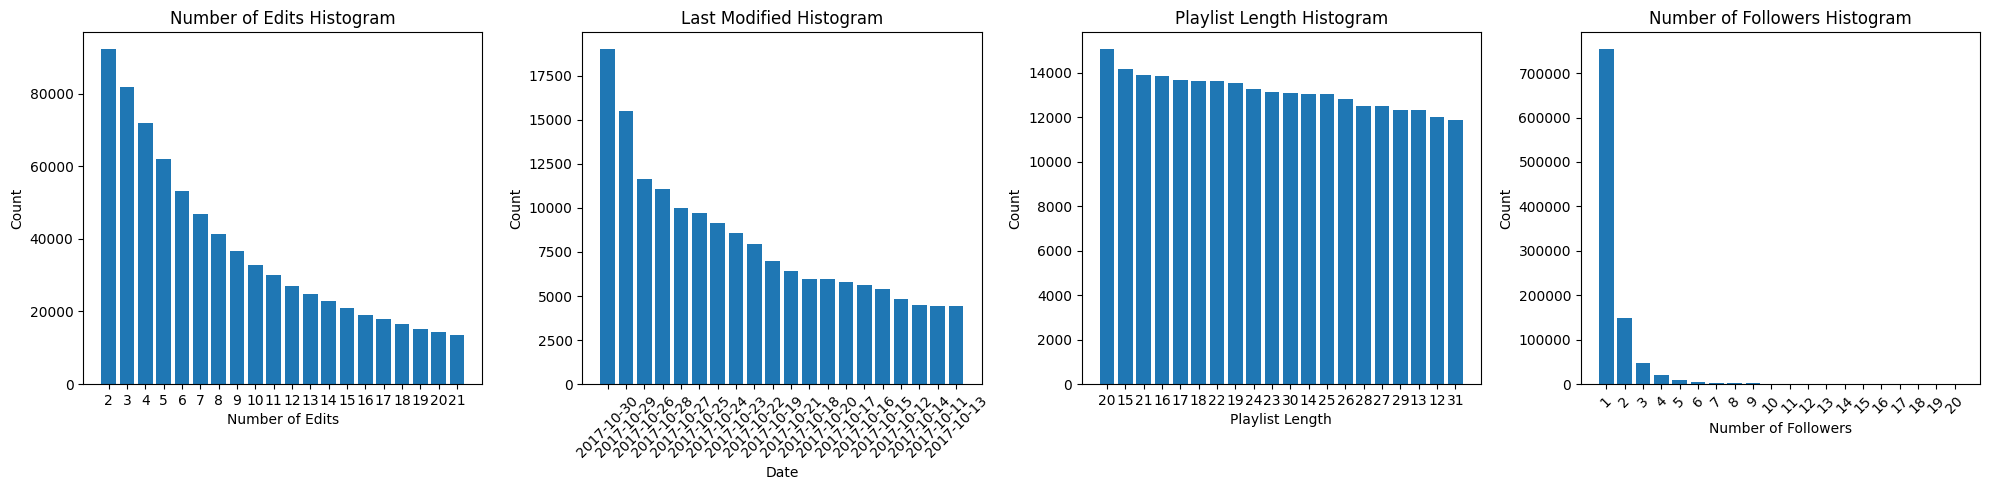

In [20]:
def plot_histograms(histograms, titles, xlabels, ylabels, rotations):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes = axes.flatten()  # in caso avessimo shape diversi della grid dei plot

    for i, ax in enumerate(axes):
        if i < len(histograms):
            data = histograms[i]
            values, counts = zip(*data)
            ax.bar(values, counts, align='center')
            ax.set_title(titles[i])
            ax.set_xlabel(xlabels[i])
            ax.set_ylabel(ylabels[i])
            ax.tick_params(axis='x', rotation=rotations[i])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Data for plotting
histograms = [numedits_histogram, last_modified_histogram,
              playlist_length_histogram, num_followers_histogram]
titles = ['Number of Edits Histogram','Last Modified Histogram',
          'Playlist Length Histogram','Number of Followers Histogram']
xlabels = ['Number of Edits', 'Date', 'Playlist Length', 'Number of Followers']
ylabels = ['Count', 'Count', 'Count', 'Count']
rotations = [0, 45, 0, 45]

plot_histograms(histograms, titles, xlabels, ylabels, rotations)

### Using the dataframe

Vediamo di capire le caratterisiche e correlazioni del nostro dataframe

In [21]:
df.describe()

,pid,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,collaborative
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,518629.500000,66.075880,49.434430,2.423710,17.498740,1.551243e+07,37.980940,0.022240
std,309662.324703,53.509518,39.847722,56.139883,20.381225,1.278239e+07,30.193669,0.147464
min,17000.000000,5.000000,2.000000,1.000000,1.000000,2.357390e+05,3.000000,0.000000
25%,263749.750000,26.000000,20.000000,1.000000,5.000000,5.998291e+06,16.000000,0.000000
50%,529499.500000,49.000000,37.000000,1.000000,10.000000,1.137176e+07,29.000000,0.000000
75%,815499.250000,91.000000,67.000000,1.000000,22.000000,2.132978e+07,51.000000,0.000000
max,992999.000000,250.000000,242.000000,7973.000000,195.000000,1.426347e+08,230.000000,1.000000


In [22]:
df.isnull().sum()  # Checking for missing values

,0
name,0
pid,0
num_tracks,0
num_albums,0
num_followers,0
num_edits,0
duration_ms,0
num_artists,0
collaborative,0
tracks,0


Utiliziamo quindi la matrice di correlazione per cercare di estrarre qualche info sulle feature delle playlist, ma prima dobbiamo eliminare colonne non numeriche (e la colonna pid)

In [23]:
df_num = df.drop(columns=['name','pid','tracks'])

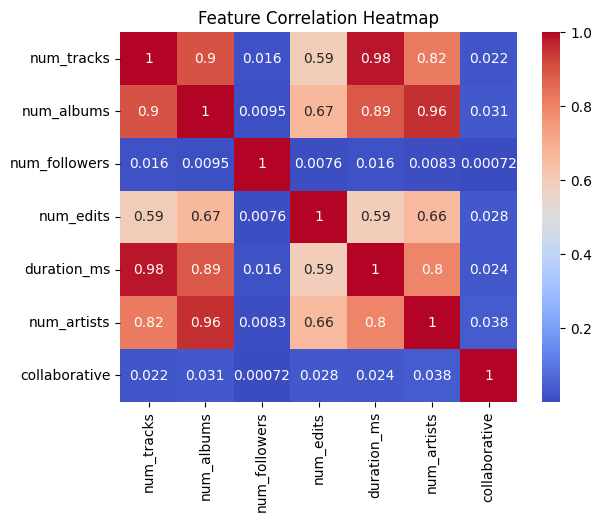

In [24]:
# Correlation heatmap
# Correlation matrix to show relationships between features
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [25]:
del df_num